In [130]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import patches as patch
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors
import time
from tqdm import tqdm
import sympy as sp

In [114]:
def get_bernstein_basis(n_val = 5):
    x, v, n = sp.symbols("x, v, n")
    b_v_n = sp.binomial(n, v)*(x**v)*((1-x)**(n-v))
    bcoeffs_x_v: list[sp.Expr] = []

    for i in range(n_val+1):
        b_nval = b_v_n.subs({v:i, n:n_val})
        b_term = sp.simplify(b_nval)
        bcoeffs_x_v.append(b_term)
    return bcoeffs_x_v


def get_ts_bernstein_basis_diff(n_val = 5):
    basis = get_bernstein_basis(n_val)
    x = sp.symbols("x")

    t, to, tf = sp.symbols("t, t_o, t_f")
    mu = (t-to)/(tf-to)
    bbterms_t: list[sp.Expr] = []
    dbbterms_t: list[sp.Expr] = []
    for b in basis:
        bbterm_mu = sp.simplify(b.subs({x:mu}))
        bbterms_t.append(bbterm_mu)
        dbbterm_t = sp.simplify(bbterm_mu.diff(t))
        dbbterms_t.append(dbbterm_t)

    return bbterms_t, dbbterms_t


def sp_time_scaling_eq(eq_t: sp.Expr, t_start: float, t_end: float, t_lim: list, k = 1/2):
    t = sp.symbols('t', positive=True, real=True)
    assert len(eq_t.free_symbols) == 1, eq_t.free_symbols.pop() == t
    deq_t = eq_t.diff(t)

    t_c1 = t_start
    t_c2 = t_end
    t1_new = t_c1
    t2_new = ((t_c2-t_c1)/k) + t_c1
    tend_new = t2_new + (t_lim[1] - t_c2)
    del_t2 = t2_new - t_c2

    new_deq_t = sp.Piecewise((deq_t, t < t1_new), 
        (k*deq_t.subs({t: k*(t-t_c1)+t_c1}), t < t2_new),
        (deq_t.subs({t: t-del_t2}), True))

    neq_t = sp.integrate(new_deq_t) + eq_t.subs({t:0})
    return neq_t, t2_new, tend_new

In [115]:
class Agent:
    def __init__(self, n_val = 5) -> None:
        self.n = n_val
        self.bb_tval, self.dbb_tval = \
            get_ts_bernstein_basis_diff(n_val)

        self.t, self.t_f, self.t_o, self.t_w = \
            sp.symbols("t, t_f, t_o, t_w")

        self.wx = [sp.symbols(f"w_{{x_{i}}}") \
            for i in range(n_val+1)]    # X
        self.wk = [sp.symbols(f"w_{{k_{i}}}") \
            for i in range(n_val+1)]    # K

        self.mx: sp.Expr = 0
        self.mdx: sp.Expr = 0
        self.mk: sp.Expr = 0
        self.mdk: sp.Expr = 0
        for i in range(n_val+1):
            self.mx += self.wx[i] * self.bb_tval[i]
            self.mdx += self.wx[i] * self.dbb_tval[i]
            self.mk += self.wk[i] * self.bb_tval[i]
            self.mdk += self.wk[i] * self.dbb_tval[i]

        self.xo, self.xw, self.xf = sp.symbols(r"x_o, x_w, x_f")
        self.dxo, self.dxw, self.dxf = \
            sp.symbols(r"\dot{x}_o, \dot{x}_w, \dot{x}_f")
        self.yo, self.yw, self.yf = sp.symbols(r"y_o, y_w, y_f")
        self.tho, self.thw, self.thf = \
            sp.symbols(r"\theta_o, \theta_w, \theta_f")
        self.ko, self.kw, self.kf = map(sp.tan, 
            (self.tho, self.thw, self.thf))

    def solve_wpt_constr(self, constrs :dict = dict(), t_nsteps = 100) -> tuple:
        bb_tval, dbb_tval = self.bb_tval, self.dbb_tval
        t, t_f, t_o, t_w = self.t, self.t_f, self.t_o, self.t_w
        wx, wk = self.wx, self.wk
        mx, mdx, mk, mdk = self.mx, self.mdx, self.mk, self.mdk
        xo, xw, xf = self.xo, self.xw, self.xf
        dxo, dxw, dxf = self.dxo, self.dxw, self.dxf
        yo, yw, yf = self.yo, self.yw, self.yf
        tho, thw, thf = self.tho, self.thw, self.thf
        ko, kw, kf = self.ko, self.kw, self.kf

        val_subs = {
            t_o: constrs.get('to', 0), t_w: constrs.get('tw', 20),
            t_f: constrs.get('tf', 50),
            xo: constrs.get('xo', 0), xw: constrs.get('xw', 5), 
            xf: constrs.get('xf', 40),
            yo: constrs.get('yo', 0), yw: constrs.get('yw', 30), 
            yf: constrs.get('yf', 40),
            ko: constrs.get('ko', np.tan(0)), 
            kw: constrs.get('kw', np.tan(np.pi/4)), 
            kf: constrs.get('kf', np.tan(0)), 
            dxo: constrs.get('dxo', 0), 
            dxf: constrs.get('dxf', 0), 
            dxw: constrs.get('dxw', 0), 
            "dko": constrs.get('dko', 0), 
            "dkw": constrs.get('dkw', 0), 
            "dkf": constrs.get('dkf', 0),
        }

        mx_equations = [
            sp.Eq(xo, mx.subs({t: t_o}).subs(val_subs)), 
            sp.Eq(xw, mx.subs({t: t_w}).subs(val_subs)), 
            sp.Eq(xf, mx.subs({t: t_f}).subs(val_subs)),
            sp.Eq(dxo, mdx.subs({t: t_o}).subs(val_subs)),
            sp.Eq(dxw, mdx.subs({t: t_w}).subs(val_subs)),
            sp.Eq(dxf, mdx.subs({t: t_f}).subs(val_subs)),
        ]
        wx_sols = sp.solve(mx_equations, wx)
        wx_subs = dict()
        for i in range(self.n + 1):
            wx_sol_i = sp.simplify(wx_sols[wx[i]]).subs(val_subs)
            wx_subs[wx[i]] = wx_sol_i
        mdxk = mdx.subs(wx_subs) * mk
        mdxk = mdxk.subs(val_subs)
        y_t = val_subs[yo] + sp.integrate(mdxk, 
            (t, val_subs[t_o], t))
        
        k_t = mk.subs(val_subs)
        dk_t = mdk.subs(val_subs)
        mk_equations = [
            sp.Eq(y_t.subs({t: val_subs[t_o]}), val_subs[yo]),
            sp.Eq(y_t.subs({t: val_subs[t_w]}), val_subs[yw]),
            sp.Eq(y_t.subs({t: val_subs[t_f]}), val_subs[yf]),
            sp.Eq(k_t.subs({t: val_subs[t_o]}), val_subs[ko]),
            sp.Eq(k_t.subs({t: val_subs[t_f]}), val_subs[kf]),
            sp.Eq(dk_t.subs({t: val_subs[t_o]}), val_subs["dko"]),
            sp.Eq(dk_t.subs({t: val_subs[t_f]}), val_subs["dkf"]),
        ]

        wk_subs = sp.solve(mk_equations, wk)

        x_ft = mx.subs(wx_subs).subs(val_subs)
        y_ft = y_t.subs(wk_subs)
        k_ft = k_t.subs(wk_subs)
        th_ft = sp.atan(k_ft)

        t_vals = np.linspace(val_subs[t_o], val_subs[t_f], t_nsteps)
        x_vals = np.array(list(map(float, [
            x_ft.subs({t: tv}) for tv in t_vals])))
        y_vals = np.array(list(map(float, [
            y_ft.subs({t: tv}) for tv in t_vals])))
        th_vals = np.array(list(map(float, [
            th_ft.subs({t: tv}) for tv in t_vals])))

        return x_vals, y_vals, th_vals, t_vals, x_ft, y_ft, th_ft


## Rule based time scaling

### Constant time scaling

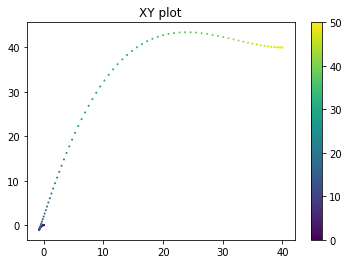

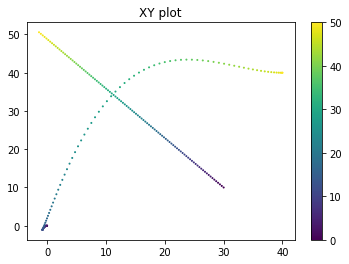

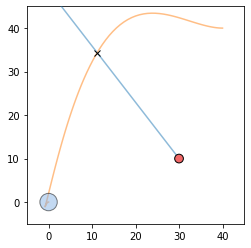

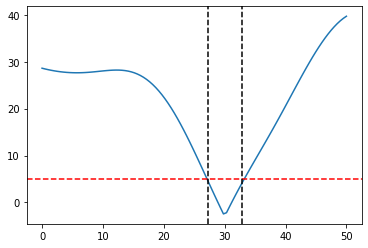

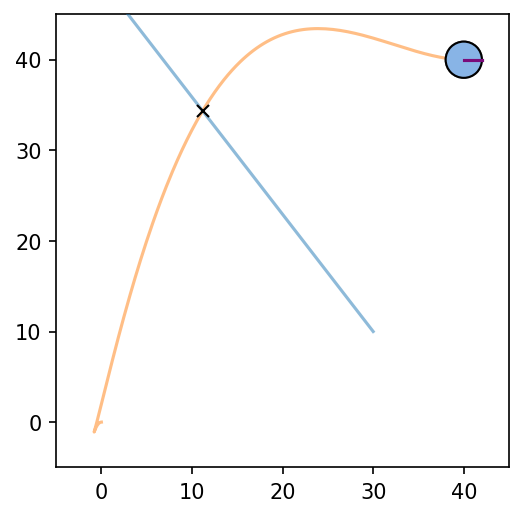

In [124]:
start_pt = [0, 0]
end_pt = [40, 40]
way_pt = [5, 20]
to, tw, tf = [0., 25., 50.]
ko, kw, kf = [0, np.tan(np.pi/4), 0]
dko, dkw, dkf = [0, 0, 0]
dxo, dxw, dxf = [0, 1, 0]

constraint_dict = {
    "to": to, "tw": tw, "tf": tf,
    "xo": start_pt[0], "xw": way_pt[0], "xf": end_pt[0],
    "yo": start_pt[1], "yw": way_pt[1], "yf": end_pt[1],
    "ko": ko, "kw": kw, "kf": kf,
    "dxo": dxo, "dxw": dxw, "dxf": dxf,
    "dko": dko, "dkw": dkw, "dkf": dkf
}

path_solver = Agent()

t_sp = sp.symbols('t', real=True, positive=True)
t_all = sp.symbols('t')

x_vals, y_vals, th_vals, t_vals, x_t, y_t, th_t = \
    path_solver.solve_wpt_constr(constraint_dict)

x_t = x_t.subs({t_all: t_sp})
y_t = y_t.subs({t_all: t_sp})
th_t = th_t.subs({t_all: t_sp})

plt.figure()
plt.title("XY plot")
plt.scatter(x_vals, y_vals, 1.0, c=t_vals)
plt.colorbar()
plt.show()

obs_t_col = 30
obs_start = (30, 10)

ox_i = float(x_t.subs({t_sp: obs_t_col}))
oy_i = float(y_t.subs({t_sp: obs_t_col}))
obs_x_t = obs_start[0] + ((ox_i - obs_start[0])/obs_t_col) * t_sp
obs_y_t = obs_start[1] + ((oy_i - obs_start[1])/obs_t_col) * t_sp

obs_t_vals = t_vals.copy()
obs_x_vals = np.array([obs_x_t.subs({t_sp: tv}) for tv in obs_t_vals])
obs_y_vals = np.array([obs_y_t.subs({t_sp: tv}) for tv in obs_t_vals])


plt.figure()
plt.title("XY plot")
plt.scatter(x_vals, y_vals, 1.0, c=t_vals)
plt.scatter(obs_x_vals, obs_y_vals, 1.0, c=t_vals)
plt.colorbar()
plt.show()

obs_rad = 1
rob_rad = 2

fig = plt.figure(num="Original Trajectory")
ax = fig.add_subplot()
ax.set_aspect('equal')

for v_i in range(len(t_vals)):
    ax.cla()
    obs_body = patch.Circle((obs_x_vals[v_i], obs_y_vals[v_i]), 
        obs_rad, ec='k', fc="#F06767", zorder=3.5)
    rob_body = patch.Circle((x_vals[v_i], y_vals[v_i]), rob_rad, 
        ec='k', fc="#88B4E6", alpha=0.5, zorder=3.4)
    ax.add_patch(obs_body)
    ax.add_patch(rob_body)
    ax.plot(obs_x_vals, obs_y_vals, alpha=0.5, zorder=3)
    ax.plot(x_vals, y_vals, alpha=0.5, zorder=3)
    ax.plot(ox_i, oy_i, 'kx', zorder=3)
    ax.set_xlim(start_pt[0]-5, end_pt[0]+5)
    ax.set_ylim(start_pt[1]-5, end_pt[1]+5)
    plt.pause(0.1)

collav_dist = 5
k_val = 0.25

dist_t = ((x_t - obs_x_t)**2 + (y_t - obs_y_t)**2)**0.5 - rob_rad - \
    obs_rad
dist_vals = np.array([dist_t.subs({t_sp: tv}) for tv in t_vals], 
    float)

t_si, t_ei = np.where(dist_vals < collav_dist)[0][[0, -1]]
t_cstart = t_vals[t_si]
t_cend = t_vals[t_ei]

plt.figure()
plt.plot(t_vals, dist_vals)
plt.axhline(collav_dist, color='r', ls='--')
plt.axvline(t_cstart, color='k', ls='--')
plt.axvline(t_cend, color='k', ls='--')
plt.show()

nx_t, t2_new, tend_new = sp_time_scaling_eq(x_t, t_cstart, t_cend, 
    [to, tf], k_val)
ny_t, t2_new, tend_new = sp_time_scaling_eq(y_t, t_cstart, t_cend,
    [to, tf], k_val)
k_t = sp.tan(th_t)
nk_t, t2_new, tend_new = sp_time_scaling_eq(k_t, t_cstart, t_cend,
    [to, tf], k_val)
nth_t = sp.atan(k_t)
nth_t = sp.atan2(ny_t.diff(t_sp), nx_t.diff(t_sp))

new_obs_x_t = sp.Piecewise((obs_x_t, t_sp < tf), 
    (obs_x_t.subs({t_sp: tf}), True))
new_obs_y_t = sp.Piecewise((obs_y_t, t_sp < tf), 
    (obs_y_t.subs({t_sp: tf}), True))

new_orig_x_t = sp.Piecewise((x_t, t_sp < tf), 
    (x_t.subs({t_sp: tf}), True))
new_orig_y_t = sp.Piecewise((y_t, t_sp < tf), 
    (y_t.subs({t_sp: tf}), True))
new_orig_th_t = sp.Piecewise((th_t, t_sp < tf), 
    (th_t.subs({t_sp: tf}), True))

new_t_vals = np.linspace(to, tend_new, 300)

obs_x_vals = np.array([new_obs_x_t.subs({t_sp: tv}) \
    for tv in new_t_vals], float)
obs_y_vals = np.array([new_obs_y_t.subs({t_sp: tv}) \
    for tv in new_t_vals], float)

orig_x_vals = np.array([new_orig_x_t.subs({t_sp: tv}) \
    for tv in new_t_vals], float)
orig_y_vals = np.array([new_orig_y_t.subs({t_sp: tv}) \
    for tv in new_t_vals], float)
orig_th_vals = np.array([new_orig_th_t.subs({t_sp: tv}) \
    for tv in new_t_vals], float)

x_vals = np.array([nx_t.subs({t_sp: tv}) \
    for tv in new_t_vals], float)
y_vals = np.array([ny_t.subs({t_sp: tv}) \
    for tv in new_t_vals], float)
th_vals = np.array([nth_t.subs({t_sp: tv}) \
    for tv in new_t_vals], float)
th_vals[-1] = 0.0

fig = plt.figure(num="Collision Avoidance", dpi=150)
ax = fig.add_subplot()
ax.set_aspect('equal')

for v_i in range(len(new_t_vals)):
    ax.cla()
    obs_body = patch.Circle((obs_x_vals[v_i], obs_y_vals[v_i]), 
        obs_rad, ec='k', fc="#F06767", zorder=3.6)
    rob_body_o = patch.Circle((orig_x_vals[v_i], orig_y_vals[v_i]), 
        rob_rad, ec='k', fc="#88B4E6", alpha=0.5, zorder=3.4)
    ax.plot(
        [orig_x_vals[v_i], orig_x_vals[v_i] + \
            rob_rad*np.cos(orig_th_vals[v_i])], 
        [orig_y_vals[v_i], orig_y_vals[v_i] + \
            rob_rad*np.sin(orig_th_vals[v_i])], c="#7A0C7A", 
        zorder=3.45, alpha=0.5)
    rob_body = patch.Circle((x_vals[v_i], y_vals[v_i]), 
        rob_rad, ec='k', fc="#88B4E6", alpha=1, zorder=3.5)
    ax.plot(
        [x_vals[v_i], x_vals[v_i] + rob_rad*np.cos(th_vals[v_i])], 
        [y_vals[v_i], y_vals[v_i] + rob_rad*np.sin(th_vals[v_i])], 
        c="#7A0C7A", zorder=3.55)
    ax.add_patch(obs_body)
    ax.add_patch(rob_body_o)
    ax.add_patch(rob_body)
    ax.plot(obs_x_vals, obs_y_vals, alpha=0.5, zorder=3)
    ax.plot(x_vals, y_vals, alpha=0.5, zorder=3)
    ax.plot(ox_i, oy_i, 'kx', zorder=3)
    ax.set_xlim(start_pt[0]-5, end_pt[0]+5)
    ax.set_ylim(start_pt[1]-5, end_pt[1]+5)
    fig.savefig(f"./data/{v_i}.png")

### Linear time scaling

Finding path
Path found


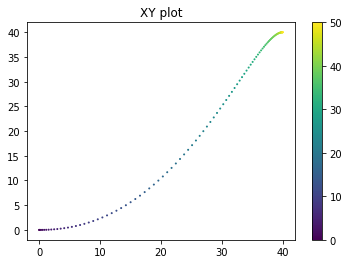

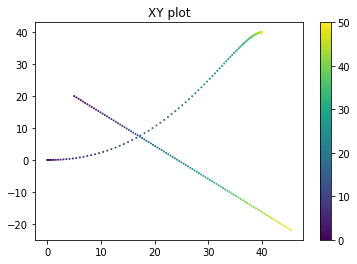

Simulation took 1.798 seconds!
Processed 353 time samples


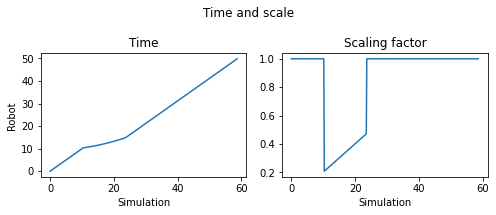

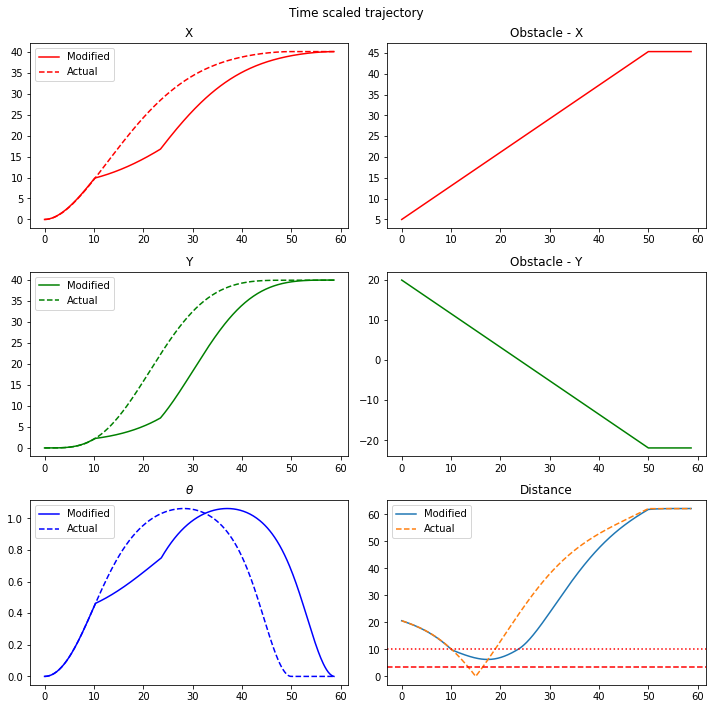

100%|██████████| 353/353 [00:31<00:00, 11.32it/s]


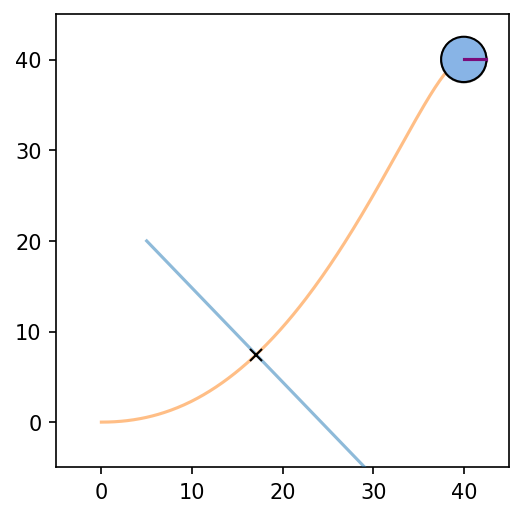

In [137]:
start_pt = [0, 0]
end_pt = [40, 40]
way_pt = [30, 25]

to, tw, tf = [0., 25., 50.]
ko, kw, kf = [0, np.tan(np.pi/4), 0]
dko, dkw, dkf = [0, 0, 0]
dxo, dxw, dxf = [0, 1, 0]

constraint_dict = {
    "to": to, "tw": tw, "tf": tf,
    "xo": start_pt[0], "xw": way_pt[0], "xf": end_pt[0],
    "yo": start_pt[1], "yw": way_pt[1], "yf": end_pt[1],
    "ko": ko, "kw": kw, "kf": kf,
    "dxo": dxo, "dxw": dxw, "dxf": dxf,
    "dko": dko, "dkw": dkw, "dkf": dkf
}

path_solver = Agent()
t_sp = sp.symbols('t', real=True, positive=True)
t_all = sp.symbols('t')
print("Finding path")

x_vals, y_vals, th_vals, t_vals, x_t, y_t, th_t = \
    path_solver.solve_wpt_constr(constraint_dict)
print("Path found")

x_t = x_t.subs({t_all: t_sp})
y_t = y_t.subs({t_all: t_sp})
th_t = th_t.subs({t_all: t_sp})

plt.figure()
plt.title("XY plot")
plt.scatter(x_vals, y_vals, 1.0, c=t_vals)
plt.colorbar()
plt.show()

obs_t_col = 15
obs_start = (5, 20)
obs_rad = 1
rob_rad = 2.5
detection_bound = 10

sfunc_a = 0.001
sfunc_b = 0.02
num_sim_samples = 300

ox_i = float(x_t.subs({t_sp: obs_t_col}))
oy_i = float(y_t.subs({t_sp: obs_t_col}))
obs_x_t = obs_start[0] + ((ox_i - obs_start[0])/obs_t_col) * t_sp
obs_y_t = obs_start[1] + ((oy_i - obs_start[1])/obs_t_col) * t_sp
obs_t_vals = t_vals.copy()
obs_x_vals = np.array([obs_x_t.subs({t_sp: tv}) for tv in obs_t_vals])
obs_y_vals = np.array([obs_y_t.subs({t_sp: tv}) for tv in obs_t_vals])

plt.figure()
plt.title("XY plot")
plt.scatter(x_vals, y_vals, 1.0, c=t_vals)
plt.scatter(obs_x_vals, obs_y_vals, 1.0, c=t_vals)
plt.colorbar()
plt.show()


start_ctime = time.time()
vx_t = x_t.diff(t_sp)
vy_t = y_t.diff(t_sp)

ovx_t = obs_x_t.diff(t_sp)
ovy_t = obs_y_t.diff(t_sp)

t_sim_start, t_sim_end = to, tf
dt_sim_k1 = (t_sim_end - t_sim_start)/num_sim_samples
t_sim = t_sim_start

t_rob_local = t_sim
dt_sim = dt_sim_k1
k_val = 1.0

r_robot = [float(x_t.subs(t_sp, t_sim)), 
    float(y_t.subs(t_sp, t_sim))]
th_robot = float(th_t.subs(t_sp, t_sim))
r_obstacle = [float(obs_x_t.subs(t_sp, t_sim)), 
    float(obs_y_t.subs(t_sp, t_sim))]

robot_poses = []
obstacle_poses = []
k_vals = []
dist_vals = []
time_vals = []
tq_bar = tqdm(total=t_sim_end, leave=False)

while t_rob_local < t_sim_end:
    dist_ro = float(((r_robot[0] - r_obstacle[0])**2 + \
        (r_robot[1] - r_obstacle[1])**2)**0.5)
    if dist_ro < detection_bound:
        k_val = sfunc_a + sfunc_b * t_sim
    else:
        k_val = 1.0

    r_obstacle = [
        float(r_obstacle[0] + ovx_t.subs(t_sp, t_sim) * dt_sim),
        float(r_obstacle[1] + ovy_t.subs(t_sp, t_sim) * dt_sim),
    ]
    robot_dx = float(k_val * vx_t.subs(t_sp, t_rob_local) * dt_sim)
    robot_dy = float(k_val * vy_t.subs(t_sp, t_rob_local) * dt_sim)
    r_robot = [
        float(r_robot[0] + robot_dx), float(r_robot[1] + robot_dy)
    ]
    th_robot = np.arctan2(robot_dy, robot_dx)

    robot_poses.append([t_sim, r_robot[0], r_robot[1], th_robot])
    obstacle_poses.append([t_sim, r_obstacle[0], r_obstacle[1]])
    k_vals.append([t_sim, k_val])
    dist_vals.append([t_sim, dist_ro])
    time_vals.append([t_sim, t_rob_local])

    t_rob_local += k_val * dt_sim
    t_sim += dt_sim
    tq_bar.update(k_val * dt_sim)
tq_bar.close()

robot_poses = np.array(robot_poses, float)
obstacle_poses = np.array(obstacle_poses, float)
k_vals = np.array(k_vals, float)
dist_vals = np.array(dist_vals, float)
time_vals = np.array(time_vals, float)
end_ctime = time.time()
print(f"Simulation took {end_ctime - start_ctime:.3f} seconds!")


res_tvals = time_vals[:, 0]
res_robposes = robot_poses[:, 1:4]

res_obsposes_x = np.array([obs_x_t.subs(t_sp, min(tv, tf)) \
    for tv in res_tvals], float)
res_obsposes_y = np.array([obs_y_t.subs(t_sp, min(tv, tf)) \
    for tv in res_tvals], float)
res_obsposes = np.stack([res_obsposes_x, res_obsposes_y]).T

res_crobotposes_x = np.array([x_t.subs(t_sp, min(tv, tf)) \
    for tv in res_tvals], float)
res_crobotposes_y = np.array([y_t.subs(t_sp, min(tv, tf)) \
    for tv in res_tvals], float)
res_crobotposes_th = np.array([th_t.subs(t_sp, min(tv, tf)) \
    for tv in res_tvals], float)
res_crobotposes = np.stack([res_crobotposes_x, res_crobotposes_y,
    res_crobotposes_th]).T

res_robposes[-1, 2] = res_crobotposes[-1, 2]

res_cdist = np.linalg.norm(res_crobotposes[:, 0:2] - \
    res_obsposes[:, 0:2], axis=1)
res_dist = np.linalg.norm(res_robposes[:, 0:2] - \
    res_obsposes[:, 0:2], axis=1)
print(f"Processed {res_tvals.shape[0]} time samples")

plt.figure(figsize=(7, 3))
plt.suptitle("Time and scale")
plt.subplot(1,2,1)
plt.title("Time")
plt.xlabel("Simulation")
plt.ylabel("Robot")
plt.plot(time_vals[:, 0], time_vals[:, 1], '-')
plt.subplot(1,2,2)
plt.title("Scaling factor")
plt.xlabel("Simulation")
plt.plot(k_vals[:, 0], k_vals[:, 1], '-')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 10))
plt.suptitle("Time scaled trajectory")
plt.subplot(3,2,1)
plt.title("X")
plt.plot(res_tvals, res_robposes[:, 0], 'r-', label="Modified")
plt.plot(res_tvals, res_crobotposes[:, 0], 'r--', label="Actual")
plt.legend()
plt.subplot(3,2,3)
plt.title("Y")
plt.plot(res_tvals, res_robposes[:, 1], 'g-', label="Modified")
plt.plot(res_tvals, res_crobotposes[:, 1], 'g--', label="Actual")
plt.legend()
plt.subplot(3,2,5)
plt.title(r"$\theta$")
plt.plot(res_tvals, res_robposes[:, 2], 'b-', label="Modified")
plt.plot(res_tvals, res_crobotposes[:, 2], 'b--', label="Actual")
plt.legend()

plt.subplot(3,2,2)
plt.title("Obstacle - X")
plt.plot(res_tvals, res_obsposes[:, 0], 'r-')
plt.subplot(3,2,4)
plt.title("Obstacle - Y")
plt.plot(res_tvals, res_obsposes[:, 1], 'g-')
plt.subplot(3,2,6)
plt.title("Distance")
plt.plot(res_tvals, res_dist, '-', label="Modified")
plt.plot(res_tvals, res_cdist, '--', label="Actual")
plt.axhline(obs_rad + rob_rad, ls='--', c='r')
plt.axhline(detection_bound, ls=':', c='r')
plt.legend()

plt.tight_layout()
plt.show()


fig = plt.figure(num="Collision Avoidance", dpi=150)
ax = fig.add_subplot()
ax.set_aspect('equal')

for v_i in tqdm(range(len(res_tvals))):
    ax.cla()
    obs_body = patch.Circle(
        (res_obsposes[v_i, 0], res_obsposes[v_i, 1]), 
        obs_rad, ec='k', fc="#F06767", zorder=3.6)
    rob_body_o = patch.Circle(
        (res_crobotposes[v_i, 0], res_crobotposes[v_i, 1]), 
        rob_rad, ec='k', fc="#88B4E6", alpha=0.5, zorder=3.4)
    ax.plot(
        [res_crobotposes[v_i, 0], res_crobotposes[v_i, 0] + \
            rob_rad*np.cos(res_crobotposes[v_i, 2])], 
        [res_crobotposes[v_i, 1], res_crobotposes[v_i, 1] + \
            rob_rad*np.sin(res_crobotposes[v_i, 2])], c="#7A0C7A", 
        zorder=3.45, alpha=0.5)
    if abs(k_vals[v_i, 1] - 1.0) > 1e-3:
        rb_ec = 'r'
        ax.plot([res_robposes[v_i, 0], res_obsposes[v_i, 0]],
            [res_robposes[v_i, 1], res_obsposes[v_i, 1]], c='r',
            lw=0.2, zorder=3.65)
    else:
        rb_ec = 'k'
    rob_body = patch.Circle(
        (res_robposes[v_i, 0], res_robposes[v_i, 1]), 
        rob_rad, ec=rb_ec, fc="#88B4E6", alpha=1, zorder=3.5)
    ax.plot(
        [res_robposes[v_i, 0], res_robposes[v_i, 0] + \
            rob_rad*np.cos(res_robposes[v_i, 2])], 
        [res_robposes[v_i, 1], res_robposes[v_i, 1] + \
            rob_rad*np.sin(res_robposes[v_i, 2])], 
        c="#7A0C7A", zorder=3.55)

    ax.add_patch(obs_body)
    ax.add_patch(rob_body_o)
    ax.add_patch(rob_body)

    ax.plot(res_obsposes[:, 0], res_obsposes[:, 1], alpha=0.5, 
        zorder=3)
    ax.plot(res_robposes[:, 0], res_robposes[:, 1], alpha=0.5, 
        zorder=3)
    ax.plot(ox_i, oy_i, 'kx', zorder=3)
    ax.set_xlim(start_pt[0]-5, end_pt[0]+5)
    ax.set_ylim(start_pt[1]-5, end_pt[1]+5)
    fig.savefig(f"./data/{v_i}.png")

## Collision cone based constant time scaling

Finding path


 34%|███▍      | 17.080528733125124/50.0 [00:12<00:01, 18.32it/s]

Path found


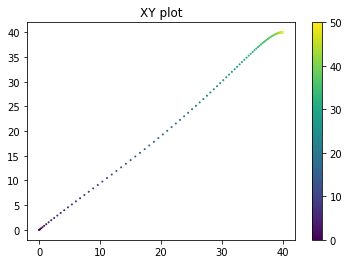

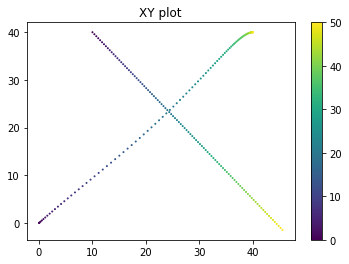


  0%|          | 0/50.0 [00:00<?, ?it/s]
  6%|▌         | 2.8333333333333326/50.0 [00:00<00:01, 27.88it/s]
 11%|█▏        | 5.666666666666668/50.0 [00:00<00:01, 27.70it/s] 
 17%|█▋        | 8.500000000000004/50.0 [00:00<00:01, 25.58it/s]
 22%|██▏       | 11.16666666666666/50.0 [00:00<00:01, 25.09it/s]
 28%|██▊       | 13.833333333333318/50.0 [00:00<00:01, 25.58it/s]
                                                                 
 39%|███▉      | 19.68333333333325/50.0 [00:10<00:35,  1.17s/it] 
 45%|████▌     | 22.68333333333327/50.0 [00:10<00:21,  1.26it/s]
 51%|█████     | 25.516666666666623/50.0 [00:10<00:13,  1.79it/s]
 57%|█████▋    | 28.516666666666644/50.0 [00:10<00:08,  2.55it/s]
 63%|██████▎   | 31.516666666666666/50.0 [00:10<00:05,  3.57it/s]
 68%|██████▊   | 34.1833333333333/50.0 [00:11<00:03,  4.73it/s]  
 74%|███████▍  | 37.016666666666595/50.0 [00:11<00:02,  6.30it/s]
 80%|████████  | 40.01666666666655/50.0 [00:11<00:01,  8.36it/s] 
 86%|████████▋ | 43.183333333333174/5

Simulation took 11.731 seconds!
Processed 346 time samples


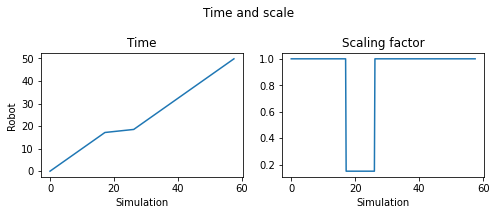

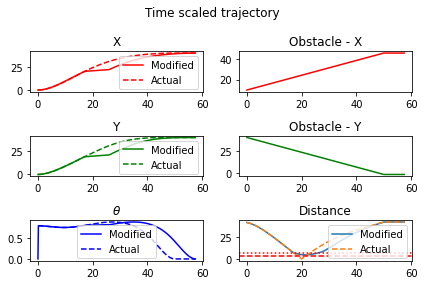

100%|██████████| 346/346 [00:29<00:00, 11.75it/s]


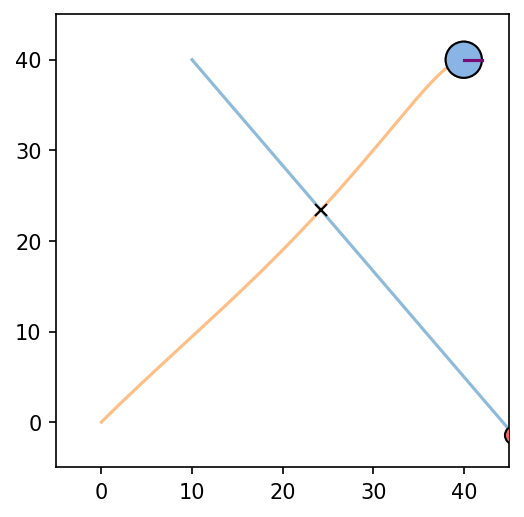

In [154]:
start_pt = [0, 0]
end_pt = [40, 40]
way_pt = [30, 30]

to, tw, tf = [0., 25., 50.]

ko, kw, kf = [np.tan(np.pi/4), np.tan(np.pi/4), 0]
dko, dkw, dkf = [0, 0, 0]
dxo, dxw, dxf = [0, 1, 0]

constraint_dict = {
    "to": to, "tw": tw, "tf": tf,
    "xo": start_pt[0], "xw": way_pt[0], "xf": end_pt[0],
    "yo": start_pt[1], "yw": way_pt[1], "yf": end_pt[1],
    "ko": ko, "kw": kw, "kf": kf,
    "dxo": dxo, "dxw": dxw, "dxf": dxf,
    "dko": dko, "dkw": dkw, "dkf": dkf
}

path_solver = Agent()
t_sp = sp.symbols('t', real=True, positive=True)
t_all = sp.symbols('t')
print("Finding path")

x_vals, y_vals, th_vals, t_vals, x_t, y_t, th_t = \
    path_solver.solve_wpt_constr(constraint_dict)
print("Path found")

x_t = x_t.subs({t_all: t_sp})
y_t = y_t.subs({t_all: t_sp})
th_t = th_t.subs({t_all: t_sp})

plt.figure()
plt.title("XY plot")
plt.scatter(x_vals, y_vals, 1.0, c=t_vals)
plt.colorbar()
plt.show()

obs_t_col = 20
obs_start = (10, 40)
obs_rad = 1
rob_rad = 2
detection_bound = 7
num_sim_samples = 300
ks_val_min = 0.15

ox_i = float(x_t.subs({t_sp: obs_t_col}))
oy_i = float(y_t.subs({t_sp: obs_t_col}))
obs_x_t = obs_start[0] + ((ox_i - obs_start[0])/obs_t_col) * t_sp
obs_y_t = obs_start[1] + ((oy_i - obs_start[1])/obs_t_col) * t_sp

obs_t_vals = t_vals.copy()
obs_x_vals = np.array([obs_x_t.subs({t_sp: tv}) for tv in obs_t_vals])
obs_y_vals = np.array([obs_y_t.subs({t_sp: tv}) for tv in obs_t_vals])

plt.figure()
plt.title("XY plot")
plt.scatter(x_vals, y_vals, 1.0, c=t_vals)
plt.scatter(obs_x_vals, obs_y_vals, 1.0, c=t_vals)
plt.colorbar()
plt.show()

x1, x2, y1, y2 = sp.symbols(r"x1, x2, y1, y2", real=True)
dx1, dy1 = sp.symbols(r"\dot{x}_1, \dot{y}_1", real=True)
dx2, dy2 = sp.symbols(r"\dot{x}_2, \dot{y}_2", real=True)
R = sp.symbols(r"R", real=True, positive=True)
s = sp.symbols(r"s", real=True)

ineq_lhs_orig = (x1-x2)**2 + (y1-y2)**2 - R**2 - (((s*dx1-dx2)*(x1-x2) + (s*dy1-dy2)*(y1-y2))**2/ ((s*dx1-dx2)**2 + (s*dy1-dy2)**2))
ineq_lhs = ineq_lhs_orig * ((s*dx1-dx2)**2 + (s*dy1-dy2)**2)
ineq_lhs_poly = sp.Poly(ineq_lhs.apart(s), s)
all_coeffs = ineq_lhs_poly.all_coeffs()

a, b, c = all_coeffs
assert a*s**2 + b*s + c == sp.simplify(ineq_lhs).apart(s)
r1 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
r2 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
d = b**2 - 4*a*c

start_ctime = time.time()

vx_t = x_t.diff(t_sp)
vy_t = y_t.diff(t_sp)

ovx_t = obs_x_t.diff(t_sp)
ovy_t = obs_y_t.diff(t_sp)

t_sim_start, t_sim_end = to, tf
dt_sim_k1 = (t_sim_end - t_sim_start)/num_sim_samples
t_sim = t_sim_start

t_rob_local = t_sim
dt_sim = dt_sim_k1
k_val = 1.0

r_robot = [float(x_t.subs(t_sp, t_sim)), 
    float(y_t.subs(t_sp, t_sim))]
th_robot = float(th_t.subs(t_sp, t_sim))
r_obstacle = [float(obs_x_t.subs(t_sp, t_sim)), 
    float(obs_y_t.subs(t_sp, t_sim))]

robot_poses = []
obstacle_poses = []
k_vals = []
dist_vals = []
time_vals = []

tq_bar = tqdm(total=t_sim_end, leave=False)

while t_rob_local < t_sim_end:
    dist_ro = float(((r_robot[0] - r_obstacle[0])**2 + \
        (r_robot[1] - r_obstacle[1])**2)**0.5)

    if dist_ro < detection_bound:
        subs_sh = {
            R: rob_rad + obs_rad,
            x1: r_robot[0], y1: r_robot[1],
            dx1: vx_t.subs(t_sp, t_rob_local),
            dy1: vy_t.subs(t_sp, t_rob_local), 
            x2: r_obstacle[0], y2: r_obstacle[1],
            dx2: ovx_t.subs(t_sp, t_sim), 
            dy2: ovy_t.subs(t_sp, t_sim)
        }

        if float(a.subs(subs_sh)) > 0:
            if float(d.subs(subs_sh)) < 0:
                k_val = ks_val_min
            else:
                r1_val = float(r1.subs(subs_sh))
                r2_val = float(r2.subs(subs_sh))
                if r1_val < ks_val_min:
                    k_val = max(r2_val, ks_val_min)
                else:
                    k_val = ks_val_min
        else:
            if float(d.subs(subs_sh)) < 0:
                raise Exception("Time scaling not possible")
            else:
                r1_val = float(r1.subs(subs_sh))
                r2_val = float(r2.subs(subs_sh))
                if r2_val < ks_val_min:
                    k_val = ks_val_min
                else:
                    k_val = max(r1_val, ks_val_min)    
    else:
        k_val = 1.0

    r_obstacle = [
        float(r_obstacle[0] + ovx_t.subs(t_sp, t_sim) * dt_sim),
        float(r_obstacle[1] + ovy_t.subs(t_sp, t_sim) * dt_sim),
    ]
    robot_dx = float(k_val * vx_t.subs(t_sp, t_rob_local) * dt_sim)
    robot_dy = float(k_val * vy_t.subs(t_sp, t_rob_local) * dt_sim)
    r_robot = [
        float(r_robot[0] + robot_dx), float(r_robot[1] + robot_dy)
    ]
    th_robot = np.arctan2(robot_dy, robot_dx)

    robot_poses.append([t_sim, r_robot[0], r_robot[1], th_robot])
    obstacle_poses.append([t_sim, r_obstacle[0], r_obstacle[1]])
    k_vals.append([t_sim, k_val])
    dist_vals.append([t_sim, dist_ro])
    time_vals.append([t_sim, t_rob_local])

    t_rob_local += k_val * dt_sim
    t_sim += dt_sim
    tq_bar.update(k_val * dt_sim)
tq_bar.close()

robot_poses = np.array(robot_poses, float)
obstacle_poses = np.array(obstacle_poses, float)
k_vals = np.array(k_vals, float)
dist_vals = np.array(dist_vals, float)
time_vals = np.array(time_vals, float)
end_ctime = time.time()
print(f"Simulation took {end_ctime - start_ctime:.3f} seconds!")

res_tvals = time_vals[:, 0]

res_robposes = robot_poses[:, 1:4]

res_obsposes_x = np.array([obs_x_t.subs(t_sp, min(tv, tf)) for tv in res_tvals], float)
res_obsposes_y = np.array([obs_y_t.subs(t_sp, min(tv, tf)) for tv in res_tvals], float)
res_obsposes = np.stack([res_obsposes_x, res_obsposes_y]).T

res_crobotposes_x = np.array([x_t.subs(t_sp, min(tv, tf)) for tv in res_tvals], float)
res_crobotposes_y = np.array([y_t.subs(t_sp, min(tv, tf)) for tv in res_tvals], float)
res_crobotposes_th = np.array([th_t.subs(t_sp, min(tv, tf)) for tv in res_tvals], float)
res_crobotposes = np.stack([res_crobotposes_x, res_crobotposes_y, res_crobotposes_th]).T

res_robposes[-1, 2] = res_crobotposes[-1, 2]

res_cdist = np.linalg.norm(res_crobotposes[:, 0:2] - res_obsposes[:, 0:2], axis=1)
res_dist = np.linalg.norm(res_robposes[:, 0:2] - res_obsposes[:, 0:2], axis=1)
print(f"Processed {res_tvals.shape[0]} time samples")

plt.figure(figsize=(7, 3))
plt.suptitle("Time and scale")
plt.subplot(1,2,1)
plt.title("Time")
plt.xlabel("Simulation")
plt.ylabel("Robot")
plt.plot(time_vals[:, 0], time_vals[:, 1], '-')
plt.subplot(1,2,2)
plt.title("Scaling factor")
plt.xlabel("Simulation")
plt.plot(k_vals[:, 0], k_vals[:, 1], '-')
plt.tight_layout()
plt.show()

plt.suptitle("Time scaled trajectory")
plt.subplot(3,2,1)
plt.title("X")
plt.plot(res_tvals, res_robposes[:, 0], 'r-', label="Modified")
plt.plot(res_tvals, res_crobotposes[:, 0], 'r--', label="Actual")
plt.legend()
plt.subplot(3,2,3)
plt.title("Y")
plt.plot(res_tvals, res_robposes[:, 1], 'g-', label="Modified")
plt.plot(res_tvals, res_crobotposes[:, 1], 'g--', label="Actual")
plt.legend()
plt.subplot(3,2,5)
plt.title(r"$\theta$")
plt.plot(res_tvals, res_robposes[:, 2], 'b-', label="Modified")
plt.plot(res_tvals, res_crobotposes[:, 2], 'b--', label="Actual")
plt.legend()

plt.subplot(3,2,2)
plt.title("Obstacle - X")
plt.plot(res_tvals, res_obsposes[:, 0], 'r-')
plt.subplot(3,2,4)
plt.title("Obstacle - Y")
plt.plot(res_tvals, res_obsposes[:, 1], 'g-')
plt.subplot(3,2,6)
plt.title("Distance")
plt.plot(res_tvals, res_dist, '-', label="Modified")
plt.plot(res_tvals, res_cdist, '--', label="Actual")
plt.axhline(obs_rad + rob_rad, ls='--', c='r')
plt.axhline(detection_bound, ls=':', c='r')
plt.legend()

plt.tight_layout()
plt.show()

fig = plt.figure(num="Collision Avoidance", dpi=150)
ax = fig.add_subplot()
ax.set_aspect('equal')

for v_i in tqdm(range(len(res_tvals))):
    ax.cla()
    obs_body = patch.Circle(
        (res_obsposes[v_i, 0], res_obsposes[v_i, 1]), 
        obs_rad, ec='k', fc="#F06767", zorder=3.6)

    rob_body_o = patch.Circle(
        (res_crobotposes[v_i, 0], res_crobotposes[v_i, 1]), 
        rob_rad, ec='k', fc="#88B4E6", alpha=0.5, zorder=3.4)
    ax.plot(
        [res_crobotposes[v_i, 0], res_crobotposes[v_i, 0] + \
            rob_rad*np.cos(res_crobotposes[v_i, 2])], 
        [res_crobotposes[v_i, 1], res_crobotposes[v_i, 1] + \
            rob_rad*np.sin(res_crobotposes[v_i, 2])], c="#7A0C7A", 
        zorder=3.45, alpha=0.5)

    if abs(k_vals[v_i, 1] - 1.0) > 1e-3:    # TS active
        rb_ec = 'r'
        ax.plot([res_robposes[v_i, 0], res_obsposes[v_i, 0]],
            [res_robposes[v_i, 1], res_obsposes[v_i, 1]], c='r',
            lw=0.2, zorder=3.65)
    else:
        rb_ec = 'k'
    rob_body = patch.Circle(
        (res_robposes[v_i, 0], res_robposes[v_i, 1]), 
        rob_rad, ec=rb_ec, fc="#88B4E6", alpha=1, zorder=3.5)
    ax.plot(
        [res_robposes[v_i, 0], res_robposes[v_i, 0] + \
            rob_rad*np.cos(res_robposes[v_i, 2])], 
        [res_robposes[v_i, 1], res_robposes[v_i, 1] + \
            rob_rad*np.sin(res_robposes[v_i, 2])], 
        c="#7A0C7A", zorder=3.55)

    ax.add_patch(obs_body)
    ax.add_patch(rob_body_o)
    ax.add_patch(rob_body)
    ax.plot(res_obsposes[:, 0], res_obsposes[:, 1], alpha=0.5, 
        zorder=3)
    ax.plot(res_robposes[:, 0], res_robposes[:, 1], alpha=0.5, 
        zorder=3)

    ax.plot(ox_i, oy_i, 'kx', zorder=3)
    ax.set_xlim(start_pt[0]-5, end_pt[0]+5)
    ax.set_ylim(start_pt[1]-5, end_pt[1]+5)

    fig.savefig(f"./data/{v_i}.png")